# Partie 1

## Modules

In [101]:
import openpyxl
from read_input import read_input

from gurobipy import *
import math
import numpy
import matplotlib.pyplot as plt
import time

## Lecture des données

In [102]:
start_time = time.time()

ville="Bordeaux" #  changer 
ressources,ressources_unavailabilities,tasks,tasks_unavailabilities = read_input(1,ville)
# "Bordeaux", "Finland", "GuineaGolf", "Italy", "Poland"

## Structures de données

In [103]:
def dist(lat1, long1, lat2, long2):
    """
    fonction renvoyant la distance en kms entre deux points décrits par leur latitude et longitude
    """
    if lat1==lat2 and long1==long2:
        return 0
    return(numpy.arccos(numpy.sin(2*numpy.pi/360*lat1)*numpy.sin(2*numpy.pi/360*lat2)+numpy.cos(2*numpy.pi/360*lat1)*numpy.cos(2*numpy.pi/360*lat2)*numpy.cos(2*numpy.pi/360*(long2-long1)))*6371)

v=5/6

L_ressources = [j for j in ressources] # tableau des objets ressources 
L_tasks = [i for i in tasks] # tableau des objets taches
number_of_ressources = len(L_ressources)
number_of_tasks = len(L_tasks)
dict_pos = {task : (task.latitude, task.longitude) for task in tasks.values()}

dict_pos = {task : (tasks[L_tasks[task]].latitude, tasks[L_tasks[task]].longitude) for task in range(number_of_tasks)}
print(dict_pos)

#distance[a][b] donne la distance de la tâche a vers la tâche b
distances = [[dist(tasks[L_tasks[a]].latitude,tasks[L_tasks[a]].longitude, tasks[L_tasks[b]].latitude, tasks[L_tasks[b]].longitude) for b in range(number_of_tasks)] for a in range(number_of_tasks)]

#distance_m[j][i] donne la distance de la maison de j la tâche i
distances_m = [[dist(ressources[L_ressources[j]].latitude,ressources[L_ressources[j]].longitude, tasks[L_tasks[i]].latitude, tasks[L_tasks[i]].longitude) for i in range(number_of_tasks)] for j in range(number_of_ressources)]
print(distances_m)

# https://gurobi.github.io/modeling-examples/technician_routing_scheduling/technician_routing_scheduling.html

{0: (44.556549383420084, -0.31939224223757195), 1: (44.967500952177986, -0.6086852638150881), 2: (45.14421541464031, -0.7342570469020379), 3: (45.264808304867096, -0.7717887212411139), 4: (45.044422793402624, -0.6687606009488057), 5: (45.19957452440505, -0.7462077931750715), 6: (45.397697776585, -0.9668192708194538), 7: (45.023479086796385, -0.8072126299796225), 8: (45.29291368453335, -0.9365361007032235), 9: (45.08146166752168, -0.8062453230620741)}
[[77.08814164266323, 26.425096734759144, 6.932258500061711, 13.231210251577162, 16.907606071776442, 8.01839052857857, 29.654865035744592, 14.251837566260903, 18.12703789054875, 7.855554978587317], [77.08814164266323, 26.425096734759144, 6.932258500061711, 13.231210251577162, 16.907606071776442, 8.01839052857857, 29.654865035744592, 14.251837566260903, 18.12703789054875, 7.855554978587317]]


## Variables de décision

In [104]:
### Create Model
m = Model("trs0")

M = 1440

print(number_of_ressources)
print(number_of_tasks)

### Decision variables
# Task-ressource assignment
x = {(t,r) : m.addVar(vtype = GRB.BINARY, name = f'x_{t}_{r}') for r in range(number_of_ressources) for t in range(number_of_tasks)}

# Time-task assignment
s = {t : m.addVar(vtype = GRB.INTEGER, lb = 0, ub = 1440, name = f's_{t}') for t in range(number_of_tasks)}
# Les s_t valent entre 0 et 1440 car les contraintes de temps (entre 8h et 18h) sont contenues dans les jeux de données.

# Est-ce que le travailleur se déplace entre les points a et b ?
y = {(r,a,b) : m.addVar(vtype = GRB.BINARY, name = f'y_{r}_{a}_{b}') for r in range(number_of_ressources) for a in range(number_of_tasks) for b in range(number_of_tasks)}# if a != b}
# Technician cannot leave or return to a depot that is not its base

# Is the worker used ?
u = {r: m.addVar(vtype = GRB.BINARY, name = f'u_{r}') for r in range(number_of_ressources)}

# starting task of worker
d = {(r,t) : m.addVar(vtype = GRB.BINARY, name = f'd_{r}_{t}') for r in range(number_of_ressources) for t in range(number_of_tasks)}
# ending task of worker
f = {(r,t) : m.addVar(vtype = GRB.BINARY, name = f'f_{r}_{t}') for r in range(number_of_ressources) for t in range(number_of_tasks)}


2
10


## Contraintes

In [105]:
# une personne est obligée de se déplacer (pas d'arrêtes de bouclage sur un point du graphe)
C4_2 = [m.addConstr(y[(r,a,a)] == 0) for r in range(number_of_ressources) for a in range(number_of_tasks)]

In [106]:
nbRpT = [LinExpr() for t in range(number_of_tasks)]
for t in range(number_of_tasks):
  for r in  range(number_of_ressources):
    nbRpT[t]+=x[(t,r)]

# One ressource per task
C1 = [m.addConstr(nbRpT[t] == 1) for t in range(number_of_tasks)]

In [107]:
nbRpTs = [LinExpr() for t in range(number_of_tasks)]
for t in range(number_of_tasks):
  for r in  range(number_of_ressources):
     nbRpTs[t]+=x[(t,r)]*(ressources[L_ressources[r]].skill!=tasks[L_tasks[r]].skill)

 # Skilled technicians
C2 = [m.addConstr(nbRpTs[t] == 0) for t in range(number_of_tasks)]

In [108]:
nbRpTl =[ LinExpr() for t in range(number_of_tasks)]
for t in range(number_of_tasks):
  for r in  range(number_of_ressources):
    nbRpTl[t]+=x[(t,r)]*(ressources[L_ressources[r]].level-tasks[L_tasks[t]].level)

# Leveled technicians
C3 = [m.addConstr(nbRpTl[t] >= 0) for t in range(number_of_tasks)]

In [109]:
# si une personne est affectée, elle arrive jusqu'à la tâche
C4 = {(i,j) : m.addConstr(quicksum(y[(j,a,i)] for a in range(number_of_tasks)) + d[(j,i)] == x[(i,j)], name = f'arrive{i}{j}') for j in range(number_of_ressources) for i in range(number_of_tasks)}

# une personne doit partir après avoir exécuté sa tâche
C5 = {(i,j) : m.addConstr(quicksum(y[(j,i,b)] for b in range(number_of_tasks)) + f[(j,i)] == x[(i,j)], name = f'part{i}{j}') for j in range(number_of_ressources) for i in range(number_of_tasks)}

In [110]:
# non overlapping tasks
print(distances[0][1]/v)
print(tasks[L_tasks[0]].duration)
C6 = [m.addConstr(s[b] >= s[a] + tasks[L_tasks[a]].duration + distances[a][b]/v -M*(1-quicksum(y[(j,a,b)] for j in range(number_of_ressources)))) for a in range(number_of_tasks) for b in range(number_of_tasks)]

61.30315499086591
60


In [111]:
# une personne doit partir de chez elle si elle travaille ce jour la
C7 = [m.addConstr(quicksum(d[(j,a)] for a in range(number_of_tasks)) == u[j]) for j in range(number_of_ressources)]
# une personne doit revenir chez elle si elle travaille ce jour la
C8 = [m.addConstr(quicksum(f[(j,b)] for b in range(number_of_tasks)) == u[j]) for j in range(number_of_ressources)]


In [112]:
# la premiere tache commence apres le début de la journée
C9 = [m.addConstr(s[i] >= ressources[L_ressources[j]].workingStart -M*(1-x[(i,j)]) + distances_m[j][i]/v) for i in range(number_of_tasks) for j in range(number_of_ressources)]

In [113]:
# la derniere tache finit avant la fin de la journee
C10 = [m.addConstr(ressources[L_ressources[j]].workingEnd >= s[i]+tasks[L_tasks[i]].duration + distances_m[j][i]/v -M*(1-x[(i,j)])) for i in range(number_of_tasks) for j in range(number_of_ressources)]

In [114]:
# contraintes permettant de respecter les horaires d'ouverture et de fermeture des taches
C11 = [m.addConstrs(s[i] >= tasks[L_tasks[i]].openingTime  -M*(1-quicksum(x[(i,j)] for j in range (number_of_ressources))) for i in range(number_of_tasks))]
C12 = [m.addConstrs(tasks[L_tasks[i]].closingTime >= s[i] + tasks[L_tasks[i]].duration - M*(1-quicksum(x[(i,j)] for j in range (number_of_ressources)))for i in range(number_of_tasks))]

## Fonction objectif et résolution

In [115]:
# -- Ajout de la fonction objectif --
couts=LinExpr()
for j in range(number_of_ressources):
  for a in range(number_of_tasks):
    for b in range(number_of_tasks):
      couts+=y[(j,a,b)]*distances[a][b]/v
    couts+=d[(j,a)]*distances_m[j][a]/v
    couts+=f[(j,a)]*distances_m[j][a]/v
m.setObjective(couts, GRB.MINIMIZE)

# -- Choix d'un paramétrage d'affichage minimaliste --
m.params.outputflag = 0 # mode muet

# -- Mise à jour du modèle  --
m.update()

# -- Affichage en mode texte du PL --
m.display()

# -- Résolution --
m.optimize()

# -- Vérification du statut et Affichage (le cas échéant) des solutions --
if m.status == GRB.INF_OR_UNBD:
    m.setParam(GRB.Param.Presolve, 0)
    m.optimize()

if m.status == GRB.INFEASIBLE:
    print(m.display(), "\n\tN'A PAS DE SOLUTION!!!")
elif m.status == GRB.UNBOUNDED:
    print(m.display(), "\n\tEST NON BORNÉ!!!")


# -- Affichage de la solution --
#print("La solution optimale est (d,q) = {} \navec pour valeur de l'objectif z = {}€".format((D.x, Q.x), m.objVal))
t=open("ResultatsV1/"+ville+"/Solution"+ville+"V1ByV4.txt",'w'.format(ville))
res="taskId;performed;employeeName;startTime;\n"
for j in range(number_of_tasks):
  p=False
  for i in range(number_of_ressources):
    if round(x[(j,i)].x):
      res+="{};{};{};{};\n".format(L_tasks[j],1,L_ressources[i],int(s[j].x))
      p=True
  if not p:
    res+="{};;;;\n".format(L_tasks[j])
print(res)
t.write(res)
t.close()

print("###########################")

for a in range(number_of_tasks):
  for b in range(number_of_tasks):
    j=0
    if  round(y[(j,a,b)].x)==1:
      print("j{} - a{} - b{} - y{} // ".format(j, a,b,y[(j,a,b)].x), end="")

#7 - 4 - 2 - 1 - 7
#8 - 6 - 8

print('\n') 
print("###########################")

for a in range(number_of_tasks):
  j=0
  if  round(d[(j,a)].x)==1:
    print("j{} - a{} - d{} // ".format(j, a,d[(j,a)].x), end="")


print('\n\n')
for a in range(number_of_tasks):
  j=0
  if  round(f[(j,a)].x)==1:
    print("j{} - a{} - d{} // ".format(j, a,f[(j,a)].x), end="")

# 3 - 5 - 2 - 9 - 7 - 4 - 1 - 0
# 6-8 okok

interval = time.time() - start_time

taskId;performed;employeeName;startTime;
T1;1;Ambre;696;
T2;1;Ambre;818;
T3;1;Valentin;576;
T4;1;Valentin;837;
T5;1;Valentin;501;
T6;1;Valentin;767;
T7;1;Valentin;923;
T8;1;Ambre;558;
T9;1;Valentin;998;
T10;1;Ambre;490;

###########################
j0 - a2 - b5 - y1.0 // j0 - a3 - b6 - y1.0 // j0 - a4 - b2 - y1.0 // j0 - a5 - b3 - y1.0 // j0 - a6 - b8 - y1.0 // 

###########################
j0 - a4 - d1.0 // 


j0 - a8 - d1.0 // 

In [116]:
print("temps de calcul : ", interval)
print("valeur de la fonction objectif : ", m.ObjVal)

temps de calcul :  3.7577266693115234
valeur de la fonction objectif :  300.70301062827735


## Visualisation de la solution

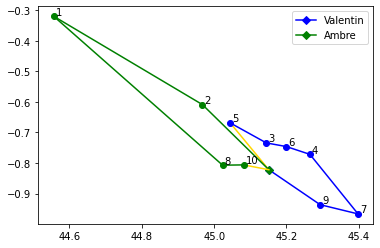

In [117]:
import matplotlib.pyplot as plt

list_colors = ['b','g','r','c','darkviolet','y','b','g','r','c','darkviolet','y','b','g','r','c','darkviolet','y','b','g','r','c','darkviolet','y']
list_light_colors = ['lightblue','lightgreen','pink','lightcyan','violet','lightyellow','lightblue','lightgreen','pink','lightcyan','violet','lightyellow','lightblue','lightgreen','pink','lightcyan','violet','lightyellow','lightblue','lightgreen','pink','lightcyan','violet','lightyellow']
number_of_colors = len(list_colors)
counter = 0
done_tasks=list()
for r in range(number_of_ressources):
  color_r = list_colors[counter % number_of_colors]
  plt.plot(ressources[L_ressources[r]].latitude,ressources[L_ressources[r]].longitude, color = color_r, marker="D", label=L_ressources[r])
  for a in range(number_of_tasks):
    for b in range(number_of_tasks):
      if round(y[(r,a,b)].x) == 1:
        plt.plot([tasks[L_tasks[a]].latitude, tasks[L_tasks[b]].latitude], [tasks[L_tasks[a]].longitude, tasks[L_tasks[b]].longitude], color = color_r)
    if round(d[(r,a)].x) == 1:
      plt.plot([tasks[L_tasks[a]].latitude, ressources[L_ressources[r]].latitude], [tasks[L_tasks[a]].longitude, ressources[L_ressources[r]].longitude], color = 'gold')
    if round(f[(r,a)].x) == 1:
      plt.plot([tasks[L_tasks[a]].latitude, ressources[L_ressources[r]].latitude], [tasks[L_tasks[a]].longitude, ressources[L_ressources[r]].longitude], color = color_r)
    if round(x[(a,r)].x) == 1 :
      done_tasks.append(a)
      plt.plot(tasks[L_tasks[a]].latitude, tasks[L_tasks[a]].longitude, color = color_r, marker="o")
      plt.annotate(str(a+1), [tasks[L_tasks[a]].latitude+0.005, tasks[L_tasks[a]].longitude+0.005])
  counter+=1

for t in range(number_of_tasks):
  if t not in done_tasks:
    plt.plot(tasks[L_tasks[t]].latitude, tasks[L_tasks[t]].longitude, color = 'black', marker="o")
    plt.annotate(str(t+1), [tasks[L_tasks[t]].latitude+0.005, tasks[L_tasks[t]].longitude+0.005])
plt.legend()
plt.savefig('ResultatsV1/'+ville+'/parcours_{}_V1.png'.format(ville), dpi=500, transparent=False)
plt.show()

(10.6, 10.724530627322407)
(14.95, 15.37463140941826)
(9.35, 9.594592398744012)
(13.783333333333333, 13.933836987888524)
(16.383333333333333, 16.62112116943892)
(12.6, 13.621719249847764)
(10.3, 11.592689422898312)
(9.166666666666666, 9.295622998066323)


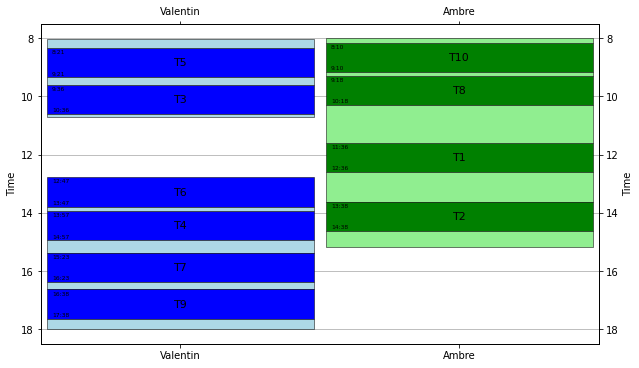

In [118]:
operators=[L_ressources[r] for r in range(number_of_ressources)]
colors=list_colors[0:number_of_ressources]
light_colors=list_light_colors[0:number_of_ressources]

fig=plt.figure(figsize=(10,5.89))

# Set Axis
ax=fig.add_subplot(111)
ax.yaxis.grid()
ax.set_xlim(0.5,len(operators)+0.5)
ax.set_ylim(18.5, 7.5)
ax.set_xticks(range(1,len(operators)+1))
ax.set_xticklabels(operators)
ax.set_ylabel('Time')

# Set Second Axis
ax2=ax.twiny().twinx()
ax2.invert_yaxis()
ax2.set_xlim(ax.get_xlim())
ax2.set_ylim(ax.get_ylim())
ax2.set_xticks(ax.get_xticks())
ax2.set_xticklabels(operators)
ax2.set_ylabel('Time')

for r in range(number_of_ressources):
    color_r = colors[r]
    light_color_r = light_colors[r]
    operator_room = r+1-0.48
    for a in range(number_of_tasks):
        if round(x[(a,r)].x) == 1 :
            event="T"+str(a+1)
            start = (int(s[a].x))/60
            end = (int(s[a].x)+tasks[L_tasks[a]].duration)/60
            plt.fill_between([operator_room, operator_room+0.96], [start, start], [end,end], color=color_r, edgecolor='k', linewidth=0.5)
            plt.text(operator_room+0.02, start+0.05 ,'{}:{}'.format(int(s[a].x)//60, int(s[a].x)%60), va='top', fontsize=6)
            plt.text(operator_room+0.02, end-0.05,'{}:{}'.format((int(s[a].x)+tasks[L_tasks[a]].duration)//60, (int(s[a].x)+tasks[L_tasks[a]].duration)%60), va='bottom', fontsize=6)
            plt.text(operator_room+0.48, (start+end)*0.5, event, ha='center', va='center', fontsize=11)
        for b in range(number_of_tasks):
            if round(y[(r,a,b)].x) == 1:
                start = (int(s[a].x)+tasks[L_tasks[a]].duration)/60
                end = start+(distances[a][b]/v)/60
                print((start,end))
                plt.fill_between([operator_room, operator_room+0.96], [start, start], [end,end], color=light_color_r, edgecolor='k', linewidth=0.5)
        if round(d[(r,a)].x) == 1:
            start = (s[a].x-distances_m[r][a]/v)/60
            end = s[a].x/60
            plt.fill_between([operator_room, operator_room+0.96], [start, start], [end,end], color=light_color_r, edgecolor='k', linewidth=0.5)
        if round(f[(r,a)].x) == 1:
            start=(s[a].x + tasks[L_tasks[a]].duration)/60
            end=start+(distances_m[r][a]/v)/60
            plt.fill_between([operator_room, operator_room+0.96], [start, start], [end,end], color=light_color_r, edgecolor='k', linewidth=0.5)

plt.savefig('ResultatsV1/'+ville+'/timetable_{}_V1.png'.format(ville), dpi=500, transparent=False)
plt.show()

In [119]:
import plotly.express as px
import pandas as pd

# plotting the working tasks
liste=[]
for i in range(number_of_ressources):
    for j in range(number_of_tasks):
        if round(x[(j,i)].x):
            start=int(s[j].x)
            end=(int(s[j].x)+tasks[L_tasks[j]].duration)
            liste.append(dict(Task=L_ressources[i], Start=start, Finish=end, Resource="executing task",J="tâche "+str(j+1)))

# plotting the transports
for a in range(number_of_tasks):
    for b in range(number_of_tasks):
        for j in range(number_of_ressources):
            if round(y[(j,a,b)].x):
                start=(int(s[a].x)+tasks[L_tasks[a]].duration)
                end=(start+distances[a][b]/v)
                liste.append(dict(Task=L_ressources[j], Start=start, Finish=end, Resource="moving",J="trajet "+str(a+1)+"-"+str(b+1)))

# plotting the first transport
for a in range(number_of_tasks):
    for j in range(number_of_ressources):
        if round(d[(j,a)].x):
            start=(s[a].x-distances_m[j][a]/v)
            end=s[a].x
            liste.append(dict(Task=L_ressources[j], Start=start, Finish=end, Resource="depart",J="trajet maison -"+str(a+1)))

# plotting the last transport
for a in range(number_of_tasks):
    for j in range(number_of_ressources):
        if round(f[(j,a)].x):
            start=(s[a].x + tasks[L_tasks[i]].duration)
            end=(start+ distances_m[j][a]/v)
            liste.append(dict(Task=L_ressources[j], Start=start, Finish=end, Resource="depart",J=str(a+1)+"- trajet maison"))

df = pd.DataFrame(liste)
df['delta'] = df['Finish'] - df['Start']

fig = px.timeline(df, x_start="Start", x_end="Finish", y="Task",text="J")

fig.layout.xaxis.type = 'linear'
fig.data[0].x = df.delta.tolist()
fig.show()

In [120]:
# check que les techniciens ont le bon niveau et les bonnes compétences pour les tâches exécutées
a = True
for i in range(number_of_ressources):
    for j in range(number_of_tasks):
        if round(x[(j,i)].x):
            # check que le skill est bon
            if ressources[L_ressources[i]].skill!=tasks[L_tasks[i]].skill:
                print("fail r,t ",i,j)
                a = False
            # check que le level est bon
            if ressources[L_ressources[i]].level < tasks[L_tasks[j]].level:
                print("fail r,t ",i,j)
                a = False
if a :
    print("Les techniciens ont bien les bonnes compétences et le bon niveau pour toutes les tâches exécutées")
            
            

Les techniciens ont bien les bonnes compétences et le bon niveau pour toutes les tâches exécutées


In [121]:
# check que les contraintes d'ouverture et de fermeture des tâches sont respectées (à réécrire pour la v2)
a = True
for i in range(number_of_ressources):
    for j in range(number_of_tasks):
        if round(x[(j,i)].x):
            if s[i].x < tasks[L_tasks[i]].openingTime:
                print("fail r,t ",i,j)
                a = False
            if tasks[L_tasks[i]].closingTime < s[i].x + tasks[L_tasks[i]].duration :
                print("fail r,t ",i,j)
                a = False

            
            
if a :
    print("Les contraintes d'ouverture et de fermeture des tâches sont respectées")


Les contraintes d'ouverture et de fermeture des tâches sont respectées



coder convexite

tout bencher

rajouter des checks sur les nouvelles contraintes, modifier l'emploi du temps (v2)

check contraites ouverture et fermeture des taches (recoder en v2)

coder qqes contraintes v2